In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import matplotlib.pyplot as plt
import pandas as pd

Load system model and generation/demand profiles from Excel, adapted from the network in Example 11_9 in PowerWorld Simulator 18 (Glover, Sarma & Overbye Edition) [Fourth Edition Sample Cases](https://www.powerworld.com/simulator-18-glover-sarma-overbye-edition-download). Generate input data.

In [2]:
model = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
gen.index+=pd.TimedeltaIndex(gen.HE-1, unit='h')
gen = gen.drop(columns='HE')
gen = gen[model['Gen']['Type']].apply(np.array, axis='columns')
gen = gen.apply(lambda x: x*np.array(model['Gen']['Installed MW']))
gen.name = 'Maximum Generation'

demand = model['LoadProfiles'].set_index('Date')
demand.index+=pd.TimedeltaIndex(demand.HE-1, unit='h')
demand = demand.drop(columns='HE')

load = demand.loc[:,demand.columns.str.contains('Load')].apply(np.array, axis='columns')
load.name = 'Fixed Load'

price = demand.loc[:,demand.columns.str.contains('Price')].apply(np.array, axis='columns')
price.name = 'Fixed Price'

results = pd.DataFrame(gen).join([load, price], how='inner')

n_days = 5
extra_days = [results.copy() for _ in range(n_days-1)]
for i, extra_day in enumerate(extra_days):
    extra_day.index += pd.Timedelta(days=i+1)
results = pd.concat([results] + extra_days)

Define as variables some problem parameters.

In [3]:
# System base, in MVA
base = 100

# Read Ybus matrix
Y = model['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)
Y = Y*100/base

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = 4*(P_line+P_line.T)/base

# The buses with generators and loads
L = np.array(model['Load']['Number of Bus']-1)
G = np.array(model['Gen']['Number of Bus']-1)

# Transformation matrices. These define the change-of-variables from the generator/load spaces to the bus space.
AG = np.zeros((N,len(G)))
AG[G,:] = np.eye(len(G))
AL = np.zeros((N,len(L)))
AL[L,:] = np.eye(len(L))

# Elasticity
elasticities = -np.array([0.5, 0.5, 0.5, 0.5])

We solve a multi-period **demand-side** problem with zero marginal cost, fixed supply, and elastic demand. For this minimal example, we make the follwing assumptions:
- Each load submits a demand curve. The system operator dispatches to maximize total utlity $U(P)$.
- For each load, elasticity is constant. That is, the marginal utility for load $i$ is given by $\frac{dU_i}{dP_i}=K_iP_i^{\frac{1}{e_i}}$, where $e_i<0$ is the elasticity. Note that this formulation insures that marginal benefit is always positive.
- There is no upper limit on consumption.

This function accepts an input dataframe as generated above and runs the full simulation. It modifies the input dataframe in-place to include the results.

In [4]:
def sim(input, b_total):

    T = len(input)

    p_g_max = np.stack(input['Maximum Generation']/base).T

    e = np.tile(elasticities,(T,1))
    e = e.T
    
    K = np.stack(input['Fixed Price'])/np.stack(input['Fixed Load']/base)**(1/e.T)
    K = K.T

    p_d = cp.Variable((len(L), T))
    p_g = cp.Variable((len(G), T))
    p_b = cp.Variable((N,T))
    b = cp.Variable(N)
    b_0 = cp.Variable(N)
    delta = cp.Variable((N, T))

    constraints = [
        AG@p_g-AL@p_d-p_b == -B@delta,
        p_g <= p_g_max,
        p_g >= 0,
        cp.cumsum(p_b, axis=1) >= -b_0[:,np.newaxis],
        cp.cumsum(p_b, axis=1) <= (b-b_0)[:,np.newaxis],
        p_b <= b[:,np.newaxis]/4,
        p_b >= -b[:,np.newaxis]/4,
        cp.sum(b) == b_total/base,
        b_0 >= 0,
        b_0 <= b
    ] + [
        cp.multiply(B, delta_t[:,np.newaxis]-delta_t[np.newaxis,:]) <= P_line 
        for delta_t in delta.T
    ]
    
    cp.Problem(
        cp.Maximize(
            cp.sum(
                cp.multiply(K*e/(1+e), cp.exp(cp.multiply((1/e+1),cp.log(p_d))))
            )
        ),
        constraints
    ).solve(max_iters=10000)

    to_column = lambda x: pd.Series(x, index=input.index)

    input['Dispatched Generation'] = to_column(list(p_g.value.T))*base
    input['Dispatched Load'] = to_column(list(p_d.value.T))*base
    input['LMP'] = -to_column(list(constraints[0].dual_value.T))
    input['Storage'] = to_column(list(p_b.value.T))*base
    input['Congestion'] = [
        B*(delta_t[:,np.newaxis]-delta_t[np.newaxis,:])
        for delta_t in delta.value.T
    ]
    input['U'] = np.sum(K*e/(1+e)*(p_d.value)**(1/e+1), axis=0)

    return np.stack([b.value, b_0.value])

Compare LMP profiles for different storage penetrations

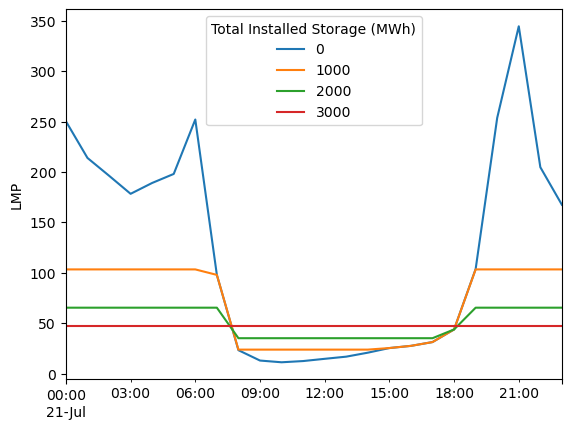

In [5]:
fig, ax = plt.subplots()
b_totals = [0, 1000, 2000, 3000]
for b_total in b_totals:
    df = results.copy()
    sim(df, b_total)
    df = df.loc[df.index.day == 21]
    df['LMP'].apply(pd.Series).mean(axis='columns').plot(ax=ax)
    ax.set_ylabel('LMP')
ax.legend(b_totals, title='Total Installed Storage (MWh)')
fig.show()

Run the simulation

In [6]:
b, b_0 = sim(results, 2000)
results = results.loc[results.index.day == 21]

Plot the results

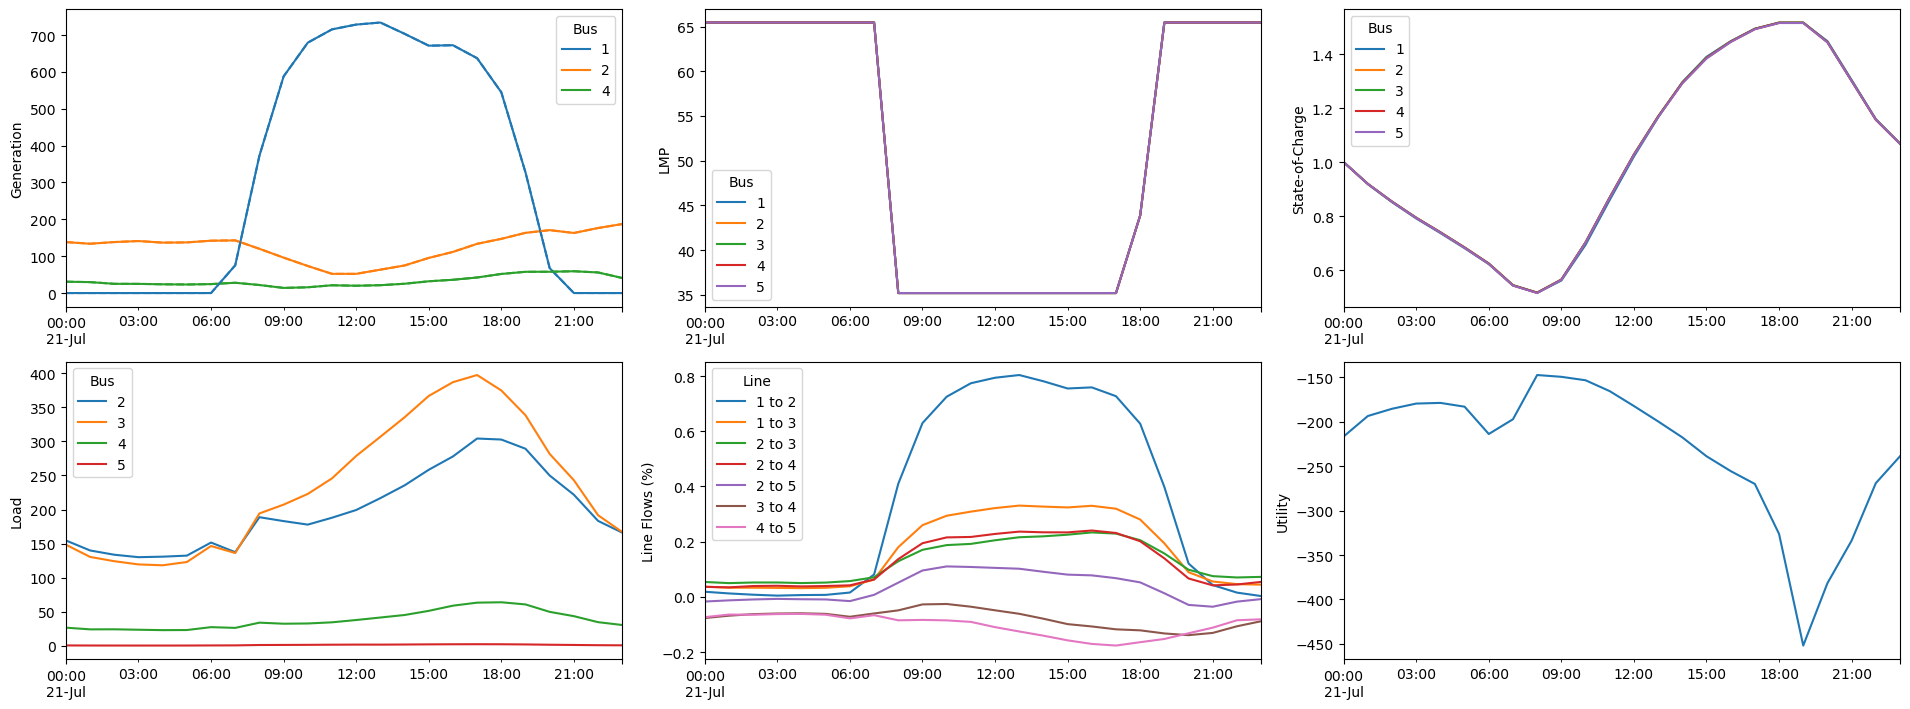

In [7]:
fig, ax = plt.subplots(2,3)

results['Dispatched Generation'].apply(pd.Series).plot(ax=ax[0,0])
colors = [line.get_color() for line in ax[0,0].lines]
results['Maximum Generation'].apply(pd.Series).plot(ax=ax[0,0], linestyle='dashed', color=colors)
ax[0,0].set_ylabel('Generation')
ax[0,0].legend(G+1, title='Bus')

results['LMP'].apply(pd.Series).plot(ax=ax[0,1])
ax[0,1].set_ylabel('LMP')
ax[0,1].legend(range(1,N+1), title='Bus')

(b_0/b+results['Storage'].apply(pd.Series).cumsum().shift().fillna(0)/b/base).plot(ax=ax[0,2])
ax[0,2].legend(range(1,N+1), title='Bus')
ax[0,2].set_ylabel('State-of-Charge')

results['Dispatched Load'].apply(pd.Series).plot(ax=ax[1,0])
ax[1,0].set_ylabel('Load')
ax[1,0].legend(L+1, title='Bus')

idx = np.array(np.where(P_line != 0))
results['Congestion'].apply(
    lambda M: pd.Series(
        {
            f'{i+1} to {j+1}': M[i,j]/P_line[i,j]
            for i, j in idx[:,idx[0] < idx[1]].T
        }
    )
).plot(ax=ax[1,1])
ax[1,1].set_ylabel('Line Flows (%)')
ax[1,1].legend(title='Line')

results['U'].plot(ax=ax[1,2])
ax[1,2].set_ylabel('Utility')

fig.set_size_inches(fig.get_size_inches()*[3,1.5])
fig.tight_layout()
fig.show()